In [19]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import KFold, ParameterGrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [20]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Loading KMNIST Dataset

In [21]:
# Define transformations for the KMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load the KMNIST dataset for training and testing
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

#### NOTE: uncoment the following section if you want to cap the dataset in order do a faster training with less data

In [22]:

# train_samples_number = 10000
# test_samples_number = 2000
# train_dataset, _ = random_split(train_dataset, [train_samples_number, len(train_dataset) - train_samples_number])
# test_dataset, _ = random_split(test_dataset, [test_samples_number, len(test_dataset) - test_samples_number])


## Definning neural network

In [23]:
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()

        # Define the layers of the neural network
        self.model = nn.Sequential(
            nn.Flatten(),  # Flatten the input from 28x28 to 784
            nn.Linear(28*28, 128),  # First fully connected layer (784 -> 512)
            nn.BatchNorm1d(128),  # Batch normalization
            nn.ReLU(),  # ReLU activation function
            nn.Dropout(0.2),  # Dropout to avoid overfitting

            nn.Linear(128, 64),  # Third fully connected layer (256 -> 128)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 10),  # Output layer (128 -> 10)
            nn.BatchNorm1d(10)
        )
        self.init_weights()  # Initialize weights

    def init_weights(self):
        # Initialize weights uniformly and set biases to zero
        for module in self.model.modules():
            if isinstance(module, nn.Linear):
                nn.init.uniform_(module.weight, a=-0.1, b=0.1)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        # Forward pass through the network
        x = self.model(x)
        x = F.softmax(x, dim=1)  # Apply softmax to output layer
        return x

In [24]:
# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data and target to the device
            output = model(data)
            total_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = total_loss / len(test_loader)
    return avg_test_loss, accuracy

#### The following train function works for each optimizer based on the "optimizer_name" will initiate the correspond optimizer 

In [25]:
# Function to train and evaluate the model
def train_and_evaluate(optimizer_name='adam', learning_rate=0.001, batch_size=64, beta1=0.9, beta2=0.999, weight_decay=0, alpha=0.99, momentum=0.9):
    train_losses = []
    test_accuracies = []
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    model = SimpleANN().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=alpha, momentum=momentum)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)

    start_time = time.time()
    
    # Training loop
    for epoch in range(10):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Move data and target to the device
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate model on the test set
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_accuracies.append(accuracy)
        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

    train_time = time.time() - start_time

    return model, train_losses, test_accuracies, train_time

In [26]:
# Plot function
def plot_results(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Definning grid parameters for each optimizer

In [27]:
adam_param_grid = {
    'learning_rate': [0.01, 0.001],
    'batch_size': [64, 128],
    'beta1': [0, 0.9],
    'beta2': [0.999, 0.9999]
}
adam_grid = ParameterGrid(adam_param_grid)

rms_param_grid = {
    'learning_rate': [0.01, 0.001],
    'batch_size': [64, 128],
    'alpha': [0.9, 0.99],  # RMSprop alpha values (similar to decay rate)
    'momentum': [0.0, 0.9]
}
rms_grid = ParameterGrid(rms_param_grid)

adamW_param_grid = {
    'learning_rate': [0.01, 0.001],
    'batch_size': [64, 128],
    'beta1': [0, 0.9],
    'beta2': [0.999, 0.9999],
    'weight_decay': [1e-6, 1e-5,],
}
adamW_grid = ParameterGrid(adamW_param_grid)

## Tranning ADAM

In [28]:
adam_results = []
for params in adam_grid:
    print(f"<---------------------- Training ADAM with params: {params} ---------------------->")
    adam_trained_model, adam_train_losses, adam_test_accuracies, adam_training_time = train_and_evaluate(optimizer_name='adam',learning_rate=params['learning_rate'], batch_size=params['batch_size'], beta1=params['beta1'], beta2=params['beta2'])
    adam_results.append((params['learning_rate'], params['batch_size'], params['beta1'], params['beta2'], adam_train_losses, adam_test_accuracies, adam_training_time))

<---------------------- Training ADAM with params: {'batch_size': 64, 'beta1': 0, 'beta2': 0.999, 'learning_rate': 0.01} ---------------------->
Epoch 1: Train Loss: 1.6656, Test Loss: 1.6665, Accuracy: 80.46%
Epoch 2: Train Loss: 1.5897, Test Loss: 1.6421, Accuracy: 82.45%
Epoch 3: Train Loss: 1.5722, Test Loss: 1.6287, Accuracy: 83.58%
Epoch 4: Train Loss: 1.5644, Test Loss: 1.6189, Accuracy: 84.59%
Epoch 5: Train Loss: 1.5576, Test Loss: 1.6142, Accuracy: 84.80%
Epoch 6: Train Loss: 1.5534, Test Loss: 1.6046, Accuracy: 85.78%
Epoch 7: Train Loss: 1.5497, Test Loss: 1.6159, Accuracy: 84.62%
Epoch 8: Train Loss: 1.5467, Test Loss: 1.6090, Accuracy: 85.20%
Epoch 9: Train Loss: 1.5428, Test Loss: 1.5947, Accuracy: 86.70%
Epoch 10: Train Loss: 1.5426, Test Loss: 1.5985, Accuracy: 86.43%
<---------------------- Training ADAM with params: {'batch_size': 64, 'beta1': 0, 'beta2': 0.999, 'learning_rate': 0.001} ---------------------->
Epoch 1: Train Loss: 1.7965, Test Loss: 1.7696, Accuracy: 

## Trainning RMSProp

In [29]:
rms_results = []
for params in rms_grid:
    print(f"<---------------------- Training RMSProp with params: {params} ---------------------->")
    rms_trained_model, rms_train_losses, rms_test_accuracies, rms_training_time = train_and_evaluate(optimizer_name='rmsprop', learning_rate=params['learning_rate'], batch_size=params['batch_size'], alpha=params['alpha'], momentum=params['momentum'])
    rms_results.append((params['learning_rate'], params['batch_size'], params['alpha'], params['momentum'], rms_train_losses, rms_test_accuracies, rms_training_time))

<---------------------- Training RMSProp with params: {'alpha': 0.9, 'batch_size': 64, 'learning_rate': 0.01, 'momentum': 0.0} ---------------------->
Epoch 1: Train Loss: 1.6597, Test Loss: 1.6690, Accuracy: 80.16%
Epoch 2: Train Loss: 1.5887, Test Loss: 1.6514, Accuracy: 81.32%
Epoch 3: Train Loss: 1.5731, Test Loss: 1.6388, Accuracy: 82.40%
Epoch 4: Train Loss: 1.5633, Test Loss: 1.6260, Accuracy: 83.67%
Epoch 5: Train Loss: 1.5560, Test Loss: 1.6169, Accuracy: 84.51%
Epoch 6: Train Loss: 1.5526, Test Loss: 1.6046, Accuracy: 85.77%
Epoch 7: Train Loss: 1.5496, Test Loss: 1.6036, Accuracy: 85.94%
Epoch 8: Train Loss: 1.5478, Test Loss: 1.5960, Accuracy: 86.57%
Epoch 9: Train Loss: 1.5456, Test Loss: 1.5955, Accuracy: 86.71%
Epoch 10: Train Loss: 1.5422, Test Loss: 1.6004, Accuracy: 86.23%
<---------------------- Training RMSProp with params: {'alpha': 0.9, 'batch_size': 64, 'learning_rate': 0.01, 'momentum': 0.9} ---------------------->
Epoch 1: Train Loss: 1.6812, Test Loss: 1.7110,

## Trainning ADAMW 

In [30]:
adamW_results = []
for params in adamW_grid:
    print(f"<---------------------- Training ADAMW with params: {params} ---------------------->")
    adamW_trained_model, adamW_train_losses, adamW_test_accuracies, adamW_training_time = train_and_evaluate(optimizer_name='adam',learning_rate=params['learning_rate'], batch_size=params['batch_size'], beta1=params['beta1'], beta2=params['beta2'], weight_decay=params['weight_decay'])
    adamW_results.append((params['learning_rate'], params['batch_size'], params['beta1'], params['beta2'], params['weight_decay'], adamW_train_losses, adamW_test_accuracies, adamW_training_time))

<---------------------- Training ADAMW with params: {'batch_size': 64, 'beta1': 0, 'beta2': 0.999, 'learning_rate': 0.01, 'weight_decay': 1e-06} ---------------------->
Epoch 1: Train Loss: 1.6659, Test Loss: 1.6726, Accuracy: 79.98%
Epoch 2: Train Loss: 1.5890, Test Loss: 1.6522, Accuracy: 81.33%
Epoch 3: Train Loss: 1.5736, Test Loss: 1.6250, Accuracy: 84.00%
Epoch 4: Train Loss: 1.5624, Test Loss: 1.6110, Accuracy: 85.39%
Epoch 5: Train Loss: 1.5559, Test Loss: 1.6092, Accuracy: 85.60%
Epoch 6: Train Loss: 1.5522, Test Loss: 1.6021, Accuracy: 86.18%
Epoch 7: Train Loss: 1.5476, Test Loss: 1.6015, Accuracy: 86.10%
Epoch 8: Train Loss: 1.5441, Test Loss: 1.6009, Accuracy: 86.10%
Epoch 9: Train Loss: 1.5424, Test Loss: 1.6471, Accuracy: 81.63%
Epoch 10: Train Loss: 1.5393, Test Loss: 1.6054, Accuracy: 85.78%
<---------------------- Training ADAMW with params: {'batch_size': 64, 'beta1': 0, 'beta2': 0.999, 'learning_rate': 0.01, 'weight_decay': 1e-05} ---------------------->
Epoch 1: Tr

## Adam Loss & Accuracy

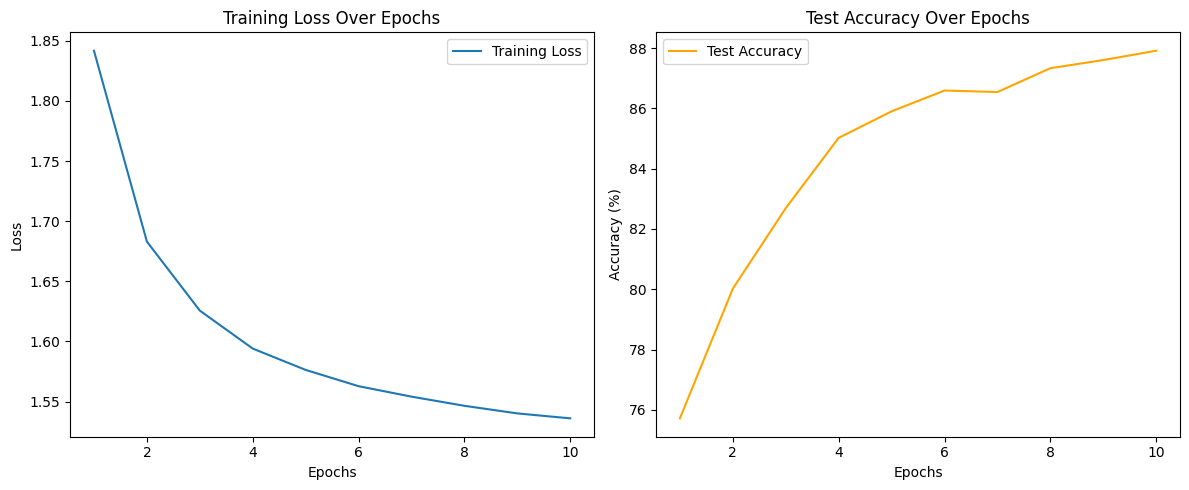

In [31]:
plot_results(adam_train_losses, adam_test_accuracies)

## RMSProp Loss & Accuracy

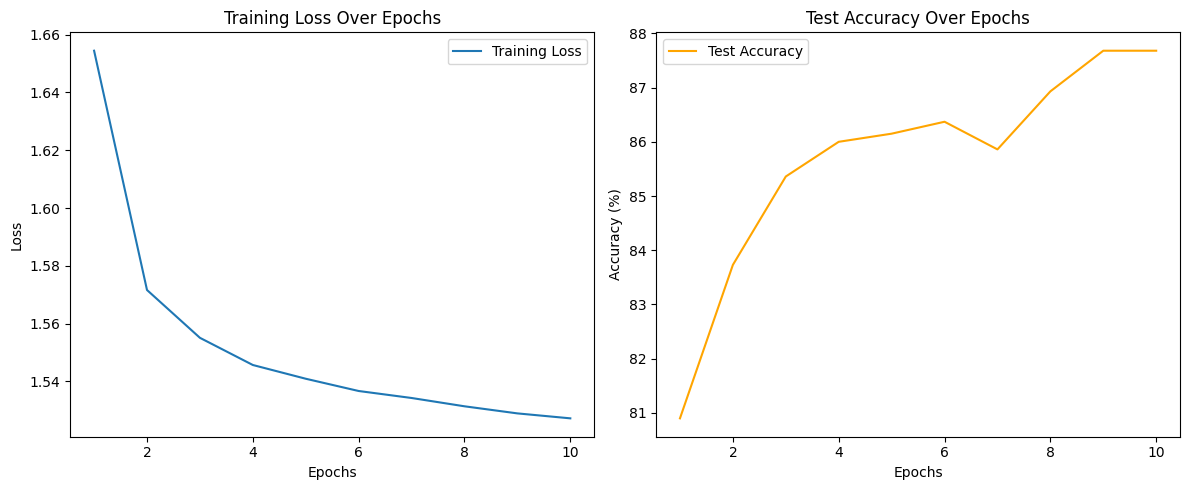

In [32]:
plot_results(rms_train_losses, rms_test_accuracies)

## AdamW Loss & Accuracy

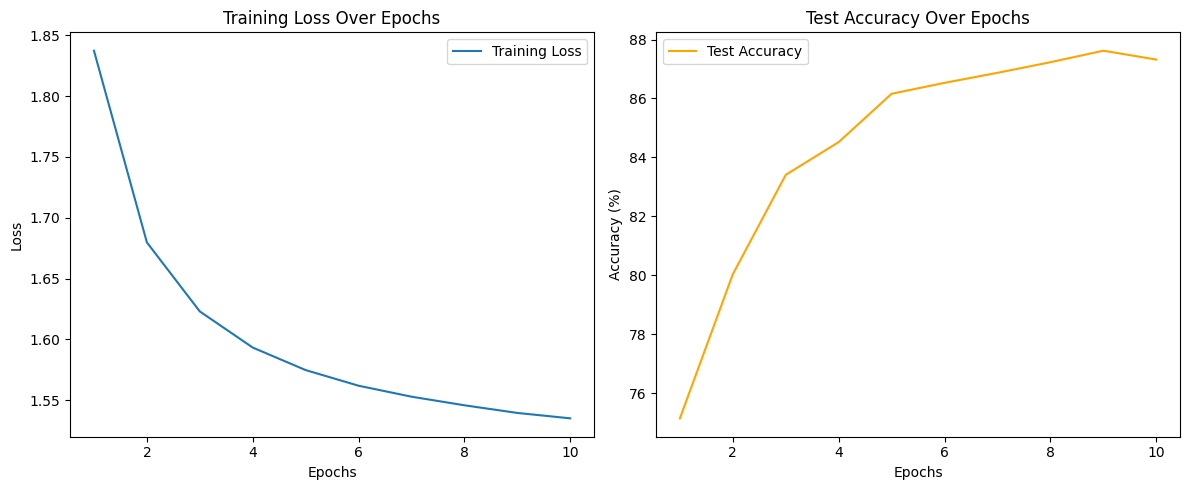

In [33]:
plot_results(adamW_train_losses, adamW_test_accuracies)

In [34]:
# Convert results to a DataFrame for comparison
adam_results_df = pd.DataFrame(adam_results, columns=['Learning Rate', 'Batch Size', 'Beta1', 'Beta2', 'Train Losses', 'Test Accuracies', 'Training Time'])
adam_results_df['Avg Test Accuracy'] = adam_results_df['Test Accuracies'].apply(lambda x: np.mean(x))
adam_results_df['Avg Train Losses'] = adam_results_df['Train Losses'].apply(lambda x: np.mean(x))
adam_results_df.drop(columns=['Train Losses', 'Test Accuracies'], inplace=True)
adam_results_df.to_csv('ADAM_Results.csv')
adam_results_df

,Learning Rate,Batch Size,Beta1,Beta2,Training Time,Avg Test Accuracy,Avg Train Losses
0,0.010,64,0.0,0.9990,207.179267,84.461,1.568473
1,0.001,64,0.0,0.9990,207.950171,84.742,1.592584
2,0.010,64,0.0,0.9999,208.553971,84.603,1.565611
3,0.001,64,0.0,0.9999,208.134453,85.154,1.595219
4,0.010,64,0.9,0.9990,205.815365,84.753,1.567214
5,0.001,64,0.9,0.9990,208.562729,84.660,1.592542
6,0.010,64,0.9,0.9999,207.970951,85.151,1.565938
7,0.001,64,0.9,0.9999,210.672299,84.797,1.594835
8,0.010,128,0.0,0.9990,178.970095,85.511,1.554570
9,0.001,128,0.0,0.9990,179.443844,84.502,1.603454


In [35]:
# Convert results to a DataFrame for comparison
rms_results_df = pd.DataFrame(rms_results, columns=['Learning Rate', 'Batch Size', 'Alpha', 'Momentum', 'Train Losses', 'Test Accuracies', 'Training Time'])
rms_results_df['Avg Test Accuracy'] = rms_results_df['Test Accuracies'].apply(lambda x: np.mean(x))
rms_results_df['Avg Train Losses'] = rms_results_df['Train Losses'].apply(lambda x: np.mean(x))
rms_results_df.drop(columns=['Train Losses', 'Test Accuracies'], inplace=True)
rms_results_df.to_csv('RMSProp_Results.csv')
rms_results_df

,Learning Rate,Batch Size,Alpha,Momentum,Training Time,Avg Test Accuracy,Avg Train Losses
0,0.010,64,0.90,0.0,188.146261,84.328,1.567860
1,0.010,64,0.90,0.9,189.580622,81.186,1.592231
2,0.001,64,0.90,0.0,185.563425,84.844,1.590906
3,0.001,64,0.90,0.9,185.827279,84.827,1.567133
4,0.010,128,0.90,0.0,163.902363,84.552,1.553521
5,0.010,128,0.90,0.9,167.439491,82.312,1.574535
6,0.001,128,0.90,0.0,164.571287,84.119,1.596164
7,0.001,128,0.90,0.9,166.424080,85.406,1.553819
8,0.010,64,0.99,0.0,192.766592,84.550,1.564998
9,0.010,64,0.99,0.9,196.295866,75.133,1.624621


In [36]:
# Convert results to a DataFrame for comparison
adamW_results_df = pd.DataFrame(adamW_results, columns=['Learning Rate', 'Batch Size', 'Beta1', 'Beta2', 'Weight Decay', 'Train Losses', 'Test Accuracies', 'Training Time'])
adamW_results_df['Avg Test Accuracy'] = adamW_results_df['Test Accuracies'].apply(lambda x: np.mean(x))
adamW_results_df['Avg Train Losses'] = adamW_results_df['Train Losses'].apply(lambda x: np.mean(x))
adamW_results_df.drop(columns=['Train Losses', 'Test Accuracies'], inplace=True)
adamW_results_df.to_csv('ADAM_Weigt_Decay_Results.csv')
adamW_results_df

,Learning Rate,Batch Size,Beta1,Beta2,Weight Decay,Training Time,Avg Test Accuracy,Avg Train Losses
0,0.010,64,0.0,0.9990,0.000001,188.089017,84.209,1.567253
1,0.010,64,0.0,0.9990,0.000010,189.279764,84.282,1.567514
2,0.001,64,0.0,0.9990,0.000001,187.704694,84.926,1.593040
3,0.001,64,0.0,0.9990,0.000010,188.595489,84.763,1.593190
4,0.010,64,0.0,0.9999,0.000001,189.206998,84.871,1.565922
5,0.010,64,0.0,0.9999,0.000010,188.982888,84.394,1.566269
6,0.001,64,0.0,0.9999,0.000001,186.897388,84.857,1.595009
7,0.001,64,0.0,0.9999,0.000010,189.121032,84.687,1.595399
8,0.010,64,0.9,0.9990,0.000001,188.349193,84.927,1.566526
9,0.010,64,0.9,0.9990,0.000010,190.243207,85.110,1.566729
